In [29]:
# Take out the comment here and install this package if it is not already on your machine
# pip install SyntheticControlMethods

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from SyntheticControlMethods import Synth
import geopandas

# Data Cleaning

In [2]:
# This function cleans our separate accident datasets, ready to be concatenated later on 
def clean_data(df, dates):
    # Restrict the dataframe to only the desired dates and create date_index for unique dates necessary
    df['DATE_INDEX'] = 0
    frames = []
    for i,date in enumerate(dates):
        match = df.loc[(df['MONTH']==date[0]) & (df['DAY']==date[1])].copy()
        match['DATE_INDEX'] = i+1
        frames.append(match)
    result = pd.concat(frames)
    
    # Drop unnecessary columns
    result = result[["STATE","ST_CASE","FATALS","YEAR","MONTH","DAY",
                     'DATE_INDEX']].sort_values(by=["STATE","MONTH","DAY"],axis=0)

    # Find the number of times of occurances of accidents
    counts_duplicates = result.groupby(['STATE','MONTH','DAY']).count()['ST_CASE']
    result = result.drop_duplicates(['STATE','MONTH','DAY']).copy()
    result['TOTAL'] = counts_duplicates.values
    
    # Drop unnecessary columns
    result = result.drop(columns=['ST_CASE','FATALS','MONTH','DAY'])
    return result

In [3]:
# Read in all the csv files
accident_2015 = pd.read_csv("Accident_2015.csv")
accident_2016 = pd.read_csv("Accident_2016.csv")
accident_2017 = pd.read_csv("Accident_2017.csv")
accident_2018 = pd.read_csv("Accident_2018.csv")
accident_2019 = pd.read_csv("Accident_2019.csv")
accident_data = [accident_2015,accident_2016,accident_2017,accident_2018,accident_2019]

/Users/Johnson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (41,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/Johnson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (41,43,70) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Creating lists of the relevant dates as ordered pairs
years_2019 = [(2,11), (2,18), (2,25), (3,4), (3,11)]
years_2018 = [(2,12), (2,19), (2,26), (3,5), (3,12)]
years_2017 = [(2,13), (2,20), (2,27), (3,6), (3,13)]
years_2016 = [(2,15), (2,22), (2,29), (3,7), (3,14)]
years_2015 = [(2,9), (2,16), (2,23), (3,2), (3,9)]
years = [years_2015,years_2016,years_2017,years_2018,years_2019]

In [5]:
# Applying our function and creating a list of that cleaned data
corrected_data = []
for df,dates in zip(accident_data,years):
    corrected_data.append(clean_data(df,dates))

In [6]:
# Concatenating our data into one dataset and reorganizing our set
all_years = pd.concat(corrected_data)
group_states = all_years.groupby(['STATE', 'DATE_INDEX'])
total_vals = group_states.mean()['TOTAL'].values
all_years = all_years.drop_duplicates(['STATE','DATE_INDEX']).copy()
all_years['AVERAGE_ACC'] = total_vals
all_years = all_years.sort_values(by=["STATE","DATE_INDEX"])
all_years = all_years.drop(columns=["YEAR","TOTAL"])
x = pd.DataFrame({'STATE':0,'DATE_INDEX':0,'AVERAGE_ACC':0},index = range(1))
all_years = all_years.append([x]*31,ignore_index=True)

In [7]:
# Developing the right columns
acc_avg = np.array([2,1.666666667,1.666666667,2.5,2.2,0,0,1.333333333,1,0,1,1,2.2,2.4,2.4,2,2.2,2,2.25,1.5,2,1,1,
                    8.4,8.2,1,7.8,6.2,6.8,2.2,0,2,1,3,1,0,3.4,2.25,1.75,0,1.666666667,3,1.5,0,0,1,1.666666667,1.75,
                    1,2,1,1,1,1,1,3.6,1.5,0,1,1,0,1,0,1,1,1,1,6.6,1.5,7.6,2.25,8,6.6,8,3.8,3.5,1.333333333,2.2,2.6,
                    1.75,1.75,2.2,1.25,4.6,2.4,4,1,2,1,1,1,1,1,1,2,1.6,1.25,0,2,2,1.666666667,2.25,1.25,2.5,2.25,2.5,
                    2,2.666666667,2.4,1,1.75,1.5,2.5,1.2,2,2,1.4,1,1.5,1.5,2,2,1.333333333,1.25,1.25,1,1.333333333,
                    1.6,2.4,2,0,0,1.75,2,2.6,2,1.75,1.5,0,1.25,1.75,4,2,2,2.4,0,0,2,2,0,1,1,1,1,1.5,1,1,1.25,1,1.75,
                    1,1.8,2,1,2,1.5,1.333333333,1,1.4,1.5,0,0,1.25,2,2.2,2,1.75,2.333333333,1,1.666666667,1.8,1,
                    1.333333333,1.666666667,1.333333333,1,1.75,3.6,1,2.5,1,2,2.75,2,2,1.8,1,1,0,0,2.5,3.25,1,1,1,0,
                    2.2,0,1,0,1,1,1,1,2,1,1,1.666666667,1,1,1,2.333333333,1,2,2.6,0,0,0,1.75,1.6,1.5,1.4,3,1,5.4,2,1,
                    1,6,1.333333333,8,7.8,1,1,1.333333333,6.8,1.333333333,2,2,1,0,0,0,1.5,1.333333333])
states = np.array([1,1,1,1,1,2,2,2,2,2,4,4,4,4,4,5,5,5,5,5,6,6,6,6,6,8,8,8,8,8,9,9,9,9,9,10,10,10,10,10,11,11,11,11,
                   11,12,12,12,12,12,13,13,13,13,13,15,15,15,15,15,16,16,16,16,16,17,17,17,17,17,18,18,18,18,18,19,
                   19,19,19,19,20,20,20,20,20,21,21,21,21,21,22,22,22,22,22,23,23,23,23,23,24,24,24,24,24,25,25,25,
                   25,25,26,26,26,26,26,27,27,27,27,27,28,28,28,28,28,29,29,29,29,29,30,30,30,30,30,31,31,31,31,31,
                   32,32,32,32,32,33,33,33,33,33,34,34,34,34,34,35,35,35,35,35,36,36,36,36,36,37,37,37,37,37,38,38,
                   38,38,38,39,39,39,39,39,40,40,40,40,40,41,41,41,41,41,42,42,42,42,42,44,44,44,44,44,45,45,45,45,
                   45,46,46,46,46,46,47,47,47,47,47,48,48,48,48,48,49,49,49,49,49,50,50,50,50,50,51,51,51,51,51,
                   53,53,53,53,53,54,54,54,54,54,55,55,55,55,55,56,56,56,56,56])
date_index = np.array([1,2,3,4,5])
date_index = np.tile(date_index,51)

In [8]:
# Setting the information correctly and dropping irrelevant information
all_years["State"] = states
all_years["Date_Index"] = date_index
all_years["Accident_AVG"] = acc_avg
all_years = all_years.drop(columns=['STATE','DATE_INDEX','AVERAGE_ACC'])
all_years = all_years[all_years.State != 15]
all_years

,State,Date_Index,Accident_AVG
0,1,1,2.000000
1,1,2,1.666667
2,1,3,1.666667
3,1,4,2.500000
4,1,5,2.200000
...,...,...,...
250,56,1,0.000000
251,56,2,0.000000
252,56,3,0.000000
253,56,4,1.500000


In [9]:
# Replacing state codes with state names
state_list = np.array(["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","District of Columbia","Florida","Georgia"
,"Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota"
,"Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina",
"North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota","Tennessee",
"Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"])
state_list = np.repeat(state_list,5)
all_years["State"] = state_list

In [10]:
# Reading in new covariates we would like to include
state_demo = pd.read_csv("state_demographics  - state_demographics .csv")
state_demo = pd.DataFrame(np.repeat(state_demo.values,5,axis=0),columns=state_demo.columns)
state_demo = state_demo.drop(columns="Index")

In [11]:
# Concatenating the new dataset
all_years.reset_index(drop=True, inplace=True)
all_years = pd.concat([all_years, state_demo], axis=1)
all_years

,State,Date_Index,Accident_AVG,population,percent_male,under_5,5_9,10_14,15_19,20_24,...,65_74,75_84,85_,under_18,over_16,over_18,over_21,over_62,over_65,percent_female
0,Alabama,1,2.000000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.1,0.05,0.02,0.23,0.80,0.78,0.73,0.2,0.17,0.52
1,Alabama,2,1.666667,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.1,0.05,0.02,0.23,0.80,0.78,0.73,0.2,0.17,0.52
2,Alabama,3,1.666667,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.1,0.05,0.02,0.23,0.80,0.78,0.73,0.2,0.17,0.52
3,Alabama,4,2.500000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.1,0.05,0.02,0.23,0.80,0.78,0.73,0.2,0.17,0.52
4,Alabama,5,2.200000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.1,0.05,0.02,0.23,0.80,0.78,0.73,0.2,0.17,0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Wyoming,1,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.1,0.05,0.02,0.24,0.79,0.77,0.72,0.2,0.16,0.49
246,Wyoming,2,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.1,0.05,0.02,0.24,0.79,0.77,0.72,0.2,0.16,0.49
247,Wyoming,3,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.1,0.05,0.02,0.24,0.79,0.77,0.72,0.2,0.16,0.49
248,Wyoming,4,1.500000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.1,0.05,0.02,0.24,0.79,0.77,0.72,0.2,0.16,0.49


In [12]:
# Reading in new covariates we would like to include and concatenating this into the main dataframe
alcohol = pd.read_csv('USEFUL-Alcohol_data.csv')
alcohol = alcohol.loc[(alcohol.year >= 2015)]
alcohol = alcohol.loc[(alcohol.state != "hawaii")]
alcohol = alcohol.loc[(alcohol.state != "us total")]
alcohol = alcohol.loc[(alcohol.state != "midwest region") & (alcohol.state != "south region") & (alcohol.state != "northeast region") & (alcohol.state != "west region")]
alcohol = alcohol.groupby(['state']).mean()
alcohol = alcohol.drop(columns=["year"])
alcohol = pd.DataFrame(np.repeat(alcohol.values,5,axis=0),columns=alcohol.columns)
all_years = pd.concat([all_years, alcohol], axis=1)

In [13]:
# Reading in new covariates we would like to include and concatenating this into the main dataframe
income= pd.read_csv("income_data.csv")
income = income.dropna()
income = income[income.columns[::2]]
income = income.T
header = income.iloc[0]
income = income[1:]
income.columns = header
income = pd.DataFrame(np.repeat(income.values,5,axis=0),columns=income.columns)
income = income.drop(columns=["index"])
income = income.replace(",","",regex=True)
income = income.apply(pd.to_numeric)
income["Population"] = all_years["population"]
income = income.div(income.Population, axis=0)
income = income.drop(columns="Population")
all_years = pd.concat([all_years, income], axis=1)

In [14]:
# Reading in new covariates we would like to include and concatenating this into the main dataframe
race = pd.read_csv("USEFUL_avg_race_data_15-19 - USEFUL_avg_race_data_15-19.csv")
race = pd.DataFrame(np.repeat(race.values,5,axis=0),columns=race.columns)
race = race.loc[(race.State != "Hawaii") & (race.State != "Grand Total")]
race = race.drop(columns="State")
race.reset_index(drop=True, inplace=True)
all_years = pd.concat([all_years, race], axis=1)
all_years.reset_index(drop=True, inplace=True)

In [15]:
# Reading in new covariates we would like to include and concatenating this into the main dataframe
weather = pd.read_csv("weather.csv")
weather = weather.drop(columns="Unnamed: 0")
weather = weather.loc[(weather.State != "Hawaii")]
virginia = weather.loc[(weather.State == "Virginia")]
virginia["State"] = "District of Columbia"
weather = pd.concat([weather,virginia],axis=0)
weather = weather.sort_values(by=["State"])
weather.reset_index(drop=True, inplace=True)
weather = pd.DataFrame(np.repeat(weather.values,5,axis=0),columns=weather.columns)
weather = weather[["Avg °F"]]
weather = weather.rename(columns={"Avg °F": "farenheit"})
all_years = pd.concat([all_years, weather], axis=1)

<ipython-input-15-0e8dca761d38>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  virginia["State"] = "District of Columbia"


In [16]:
# Creating the polynomial and interaction features in our dataset
x = all_years.loc[:,[x for x in all_years.columns if x in ("farenheit","White","Black","NativeAmerican","Asian","PacificIslander")]]
poly = PolynomialFeatures(2)
y = poly.fit_transform(x)
names = poly.get_feature_names(x.columns)
int_features = pd.DataFrame(y,columns=names)
cols_to_drop = int_features.columns[0:7]
int_features = int_features.drop(columns=cols_to_drop)
for i in int_features.columns:
    if i not in ('White^2','Black^2','NativeAmerican^2','Asian^2','farenheit^2','PacificIslander^2'):
        int_features = int_features.drop(columns=i)
int_features

,White^2,Black^2,NativeAmerican^2,Asian^2,PacificIslander^2,farenheit^2
0,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
1,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
2,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
3,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
4,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
...,...,...,...,...,...,...
245,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00
246,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00
247,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00
248,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00


In [17]:
# Adding the polynomial and interacted features into our all_years dataset
all_years = pd.concat([all_years,int_features], axis=1)
all_years

,State,Date_Index,Accident_AVG,population,percent_male,under_5,5_9,10_14,15_19,20_24,...,Asian,PacificIslander,Two_or_more_races,farenheit,White^2,Black^2,NativeAmerican^2,Asian^2,PacificIslander^2,farenheit^2
0,Alabama,1,2.000000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0145151,0.00102333,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
1,Alabama,2,1.666667,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0145151,0.00102333,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
2,Alabama,3,1.666667,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0145151,0.00102333,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
3,Alabama,4,2.500000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0145151,0.00102333,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
4,Alabama,5,2.200000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0145151,0.00102333,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Wyoming,1,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.0104733,0.00101851,0.0210791,42,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00
246,Wyoming,2,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.0104733,0.00101851,0.0210791,42,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00
247,Wyoming,3,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.0104733,0.00101851,0.0210791,42,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00
248,Wyoming,4,1.500000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.0104733,0.00101851,0.0210791,42,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00


# Visualizations

In [18]:
# Here we merely describe the summary statistics of the columns of our data
all_years.describe()

,Date_Index,Accident_AVG,population,percent_male,under_5,5_9,10_14,15_19,20_24,25_34,...,poverty_Female_employed,poverty_Unemployed,poverty_Male_unemployed,poverty_Female_unemployed,White^2,Black^2,NativeAmerican^2,Asian^2,PacificIslander^2,farenheit^2
count,250.000000,250.000000,2.500000e+02,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02,250.000000
mean,3.000000,1.804333,6.465514e+06,0.494400,0.060800,0.062600,0.064000,0.066000,0.069000,0.137800,...,0.017027,0.008052,0.003967,0.004085,0.643289,0.025788,0.001356,0.002170,1.053713e-05,2735.187800
std,1.417051,1.613386,7.256676e+06,0.008056,0.006598,0.007712,0.006942,0.005668,0.005396,0.016439,...,0.002819,0.002309,0.001012,0.001396,0.161463,0.042827,0.003992,0.003688,3.132562e-05,851.301711
min,1.000000,0.000000,5.810240e+05,0.470000,0.050000,0.050000,0.040000,0.050000,0.060000,0.120000,...,0.010454,0.004270,0.002244,0.001948,0.202927,0.000034,0.000006,0.000069,8.129170e-08,707.560000
25%,2.000000,1.000000,1.817305e+06,0.490000,0.060000,0.060000,0.060000,0.060000,0.070000,0.130000,...,0.015377,0.006342,0.003193,0.003097,0.524533,0.001383,0.000029,0.000305,4.931382e-07,2043.040000
50%,3.000000,1.500000,4.556707e+06,0.490000,0.060000,0.060000,0.060000,0.070000,0.070000,0.130000,...,0.017789,0.008075,0.003929,0.004025,0.667646,0.007332,0.000057,0.000846,1.170633e-06,2621.690000
75%,4.000000,2.000000,7.404107e+06,0.500000,0.060000,0.070000,0.070000,0.070000,0.070000,0.140000,...,0.018815,0.009232,0.004352,0.004910,0.761812,0.028480,0.000269,0.002264,2.454702e-06,3317.760000
max,5.000000,8.400000,3.928350e+07,0.520000,0.080000,0.090000,0.080000,0.080000,0.090000,0.230000,...,0.024261,0.016567,0.006870,0.009697,0.896350,0.222724,0.023704,0.022648,1.866201e-04,4998.490000


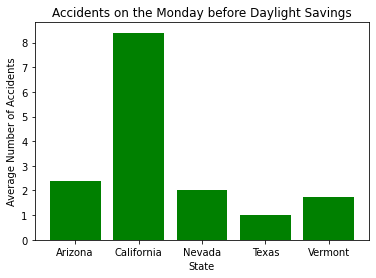

In [19]:
# A visualization about the average number of accidents the Monday of Daylight Savings
x_pos = ["Arizona","California","Nevada","Texas","Vermont"]
juststates = all_years[all_years["State"].isin(x_pos)]
y_pos = juststates[juststates["Date_Index"]==4]["Accident_AVG"]    
plt.bar(x_pos, y_pos, color='green')
plt.xlabel("State")
plt.ylabel("Average Number of Accidents")
plt.title("Accidents on the Monday before Daylight Savings")
plt.show()

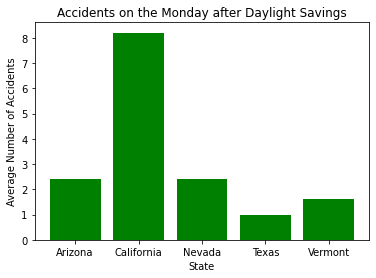

In [20]:
# A visualization about the average number of accidents the Monday of Daylight Savings
x_pos = ["Arizona","California","Nevada","Texas","Vermont"]
juststates = all_years[all_years["State"].isin(x_pos)]
y_pos = juststates[juststates["Date_Index"]==5]["Accident_AVG"]    
plt.bar(x_pos, y_pos, color='green')
plt.xlabel("State")
plt.ylabel("Average Number of Accidents")
plt.title("Accidents on the Monday after Daylight Savings")
plt.show()

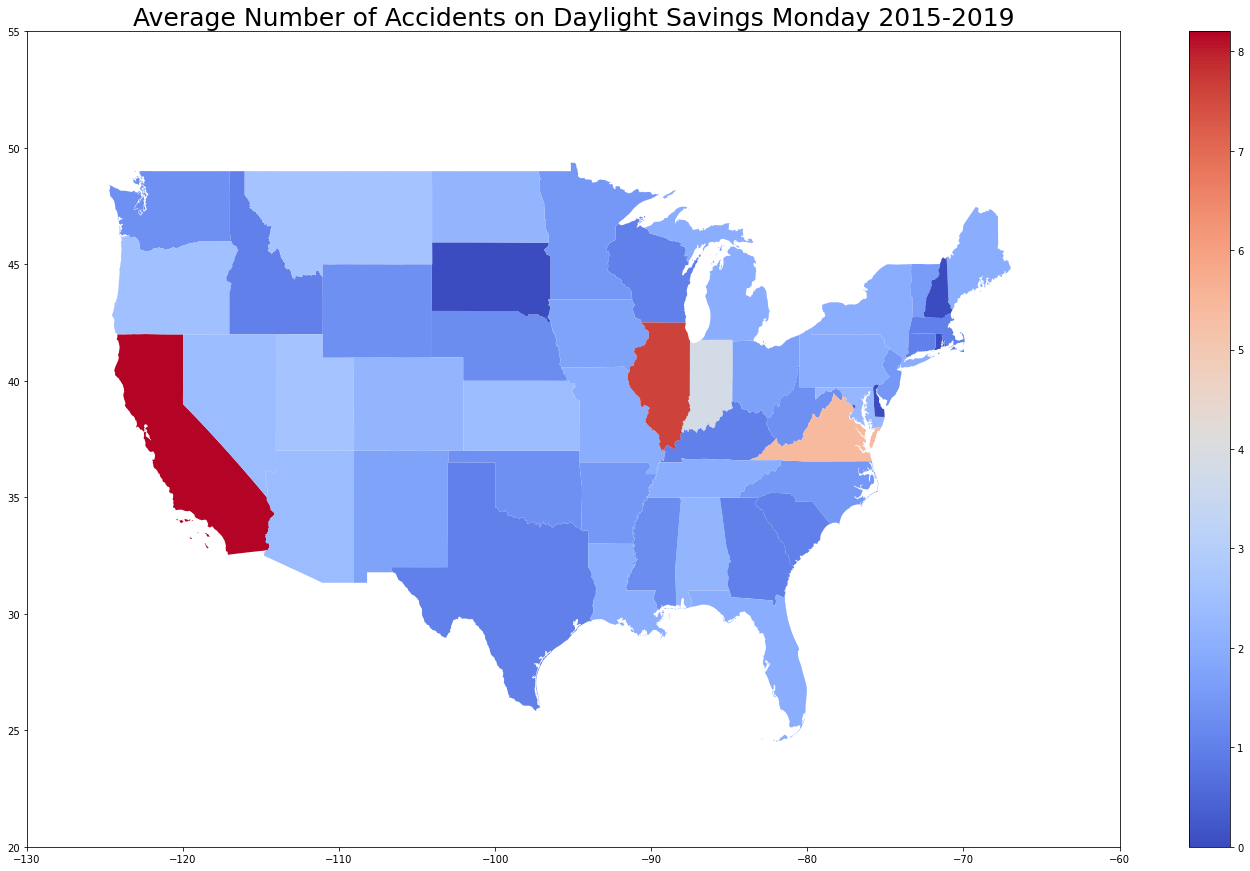

In [21]:
# Here we make a map showing the relative levels of average accidents on the Monday after Daylight 
# Savings between the states
all_years2 = all_years.iloc[4::5]
all_years2 = all_years2.rename(columns={"State": "NAME"})
all_years2 = all_years2.loc[:,[x for x in all_years2.columns if x in ("NAME","Accident_AVG")]]
all_years2.reset_index(drop=True, inplace=True)
path="/Users/Johnson/Downloads/cb_2018_us_state_5m"
geo_usa = geopandas.read_file(path)

geo_merge = geo_usa.merge(all_years2,on="NAME")
geo_merge.plot(column="Accident_AVG",figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Average Number of Accidents on Daylight Savings Monday 2015-2019',fontsize=25)
plt.show()

# ML and Synthetic Control

In [22]:
# Here we are creating and indicator for treatment and an indicator for being the last Monday before Daylight Monday
accident = all_years
accident["Arizona"] = 0
accident.loc[accident.State==4,"Arizona"] = 1
accident["Week4"] = accident["Accident_AVG"]
accident["Week4"].iloc[::5] = 0
accident["Week4"].iloc[1::5] = 0
accident["Week4"].iloc[2::5] = 0
accident["Week4"].iloc[4::5] = 0
accident

/Users/Johnson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,State,Date_Index,Accident_AVG,population,percent_male,under_5,5_9,10_14,15_19,20_24,...,Two_or_more_races,farenheit,White^2,Black^2,NativeAmerican^2,Asian^2,PacificIslander^2,farenheit^2,Arizona,Week4
0,Alabama,1,2.000000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84,0,0.0
1,Alabama,2,1.666667,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84,0,0.0
2,Alabama,3,1.666667,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84,0,0.0
3,Alabama,4,2.500000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84,0,2.5
4,Alabama,5,2.200000,4876250.0,0.48,0.06,0.06,0.06,0.07,0.07,...,0.0168564,62.8,0.480132,0.071676,0.000049,0.000211,0.000001,3943.84,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Wyoming,1,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.0210791,42,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00,0,0.0
246,Wyoming,2,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.0210791,42,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00,0,0.0
247,Wyoming,3,0.000000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.0210791,42,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00,0,0.0
248,Wyoming,4,1.500000,581024.0,0.51,0.06,0.07,0.07,0.06,0.07,...,0.0210791,42,0.860234,0.000162,0.000741,0.000110,0.000001,1764.00,0,1.5


In [23]:
# Creating the treatment vector, the output vector, and our vector of characteristics
d = accident["Arizona"]
y = accident["Accident_AVG"]
X = accident.loc[:,[x for x in accident.columns if x not in ("Arizona","Accident_AVG","Date_Index","State","Week4")]]

In [24]:
# Train, test split for running our gridsearch
X_train, X_test, d_train, d_test, y_train, y_test = train_test_split(X, d, y, random_state=42)

In [25]:
# GridSearch for our lasso regression of d on our x's
alpha_grid = {'alpha': [.0001, .001, .05, .01, .1],'max_iter': [100000]}
d_reg = GridSearchCV(Lasso(), alpha_grid, scoring="neg_mean_squared_error", n_jobs=-1)
d_reg.fit(X_train,d_train)
print(d_reg.best_params_, sep="\n")
print("This is the test set accuracy for this lasso regression of d on X: " + str(d_reg.score(X_test,d_test)))

{'alpha': 0.0001, 'max_iter': 100000}
This is the test set accuracy for this lasso regression of d on X: -0.0


/Users/Johnson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


In [26]:
# GridSearch for our lasso regression of y on our x's
alpha_grid = {'alpha': [.0001, .001, .02, .01, .1],'max_iter': [100000]}
y_reg = GridSearchCV(Lasso(), alpha_grid, scoring="neg_mean_squared_error", n_jobs=-1)
y_reg.fit(X_train,y_train)
print(y_reg.best_params_, sep="\n")
print("This is the test set accuracy for this lasso regression of y on X: " + str(y_reg.score(X_test,y_test)))

{'alpha': 0.1, 'max_iter': 100000}
This is the test set accuracy for this lasso regression of y on X: -4.137491623458062


In [27]:
# This is Post Double Selection (just applying the alpha value found above)
d_reg = Lasso(alpha=.0001,max_iter=100000).fit(X, d)
y_reg = Lasso(alpha=.1,max_iter=100000).fit(X, y)
union = X.iloc[:,(d_reg.coef_!=0) + (y_reg.coef_!=0)]
combined = pd.concat([accident["State"],accident["Date_Index"],accident["Week4"],y,union], axis=1)

/Users/Johnson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


In [28]:
# We had to take out farenheit because the Synth method below didn't work with it 
# included, but we should find a way to include it
combined = combined.loc[:,[x for x in combined.columns if x not in ("farenheit")]]
combined

,State,Date_Index,Week4,Accident_AVG,population,number_of_beers,number_of_glasses_wine,number_of_shots_liquor,farenheit^2
0,Alabama,1,0.0,2.000000,4876250.0,255.407407,51.596899,137.550689,3943.84
1,Alabama,2,0.0,1.666667,4876250.0,255.407407,51.596899,137.550689,3943.84
2,Alabama,3,0.0,1.666667,4876250.0,255.407407,51.596899,137.550689,3943.84
3,Alabama,4,2.5,2.500000,4876250.0,255.407407,51.596899,137.550689,3943.84
4,Alabama,5,0.0,2.200000,4876250.0,255.407407,51.596899,137.550689,3943.84
...,...,...,...,...,...,...,...,...,...
245,Wyoming,1,0.0,0.000000,581024.0,285.629630,63.007752,248.110300,1764.00
246,Wyoming,2,0.0,0.000000,581024.0,285.629630,63.007752,248.110300,1764.00
247,Wyoming,3,0.0,0.000000,581024.0,285.629630,63.007752,248.110300,1764.00
248,Wyoming,4,1.5,1.500000,581024.0,285.629630,63.007752,248.110300,1764.00


In [26]:
# This is the actual synthetic control object we create
sc = Synth(combined,"Accident_AVG", "State", "Date_Index", 5, "Arizona", pen=0)

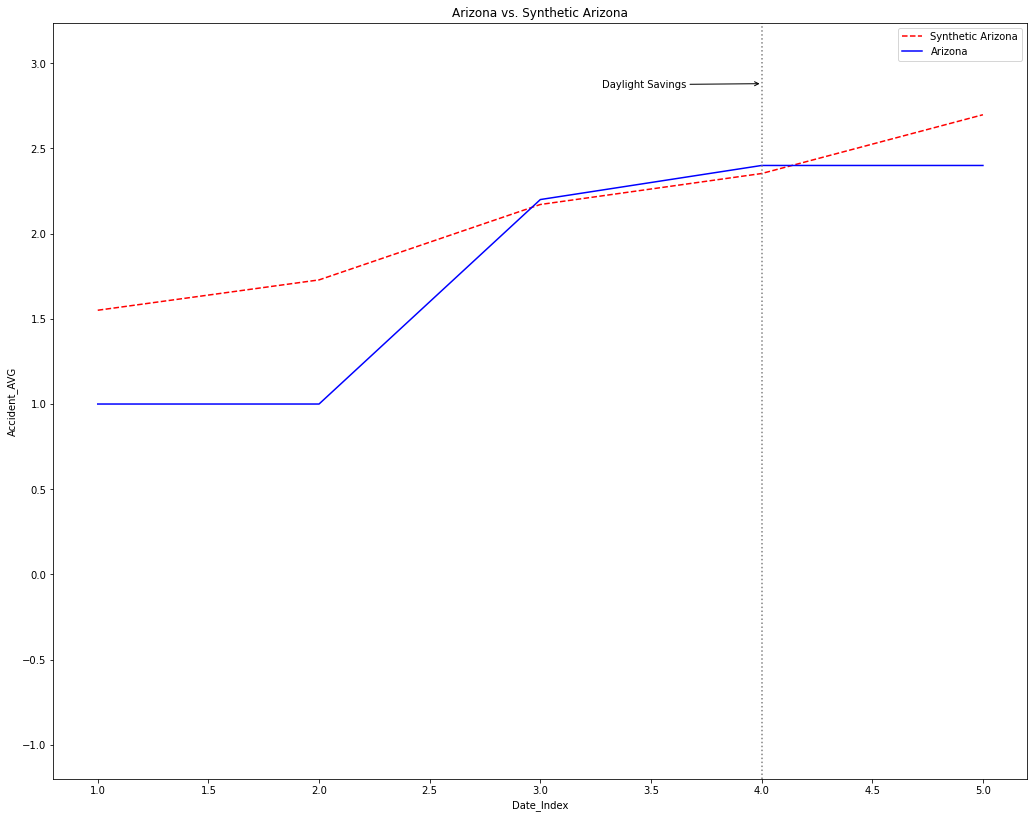

In [27]:
# This is the plot
sc.plot(["original"], treated_label="Arizona", synth_label="Synthetic Arizona", treatment_label="Daylight Savings")

In [28]:
# This is the weight matrix, or, what synthetic Arizona is made out of
sc.original_data.weight_df

,Weight
Alabama,0.022643
California,0.074501
Colorado,0.010931
Florida,0.061600
Georgia,0.050998
Illinois,0.055202
Indiana,0.033156
Kentucky,0.016473
Maryland,0.028270
Massachusetts,0.029003


In [29]:
# This is a matrix of comparisons on important variables between synthetic and real Arizona
sc.original_data.comparison_df

,Arizona,Synthetic Arizona,WMAPE,Importance
Week4,0.60,0.59,0.42,0.14
Accident_AVG,1.65,1.95,0.65,0.14
population,7050299.00,13729152.34,7529807.02,0.15
number_of_beers,266.07,245.89,32.25,0.14
number_of_glasses_wine,78.39,81.78,20.85,0.14
number_of_shots_liquor,163.50,166.30,22.98,0.14
farenheit^2,3636.09,3088.20,868.19,0.15


/Users/Johnson/opt/anaconda3/lib/python3.8/site-packages/SyntheticControlMethods/plot.py:235: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


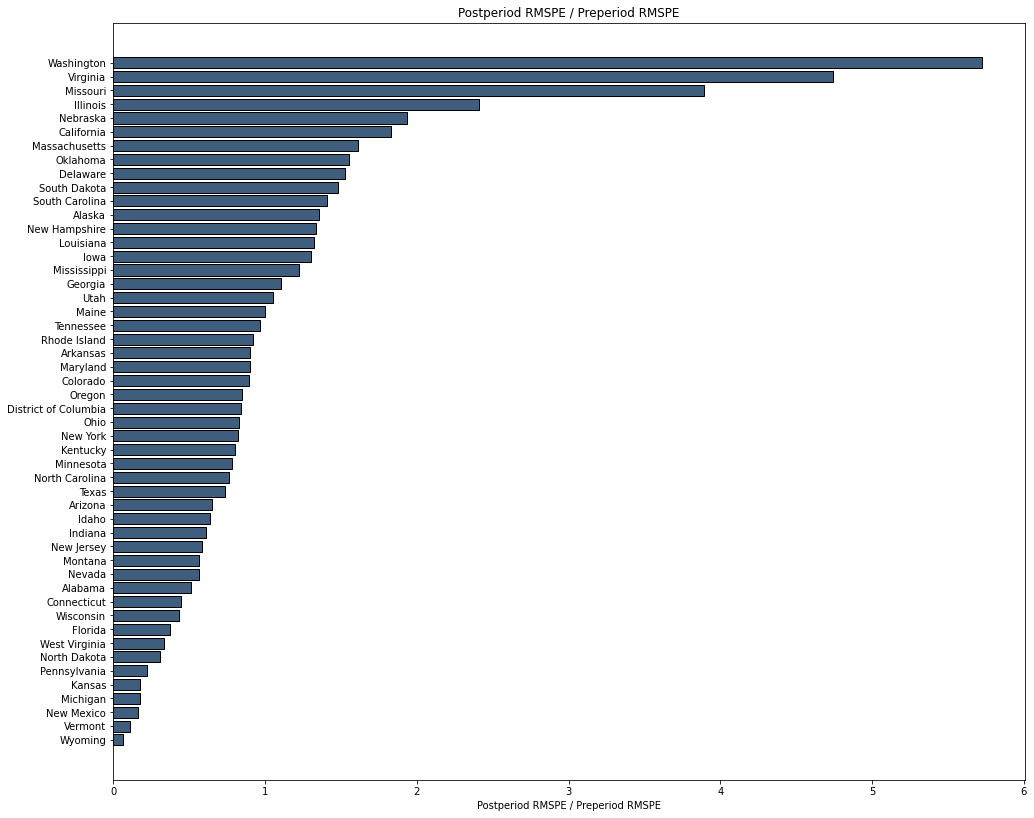

In [30]:
# Compute in-space placebos - This is how we calculate inference
sc.in_space_placebo(1)
sc.plot(['rmspe ratio'])